> # Dependencies

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

> # Load Data

In [2]:
def read_images(data_dir, labeling):
    data, label = [], []
    for image in (sorted(os.listdir(data_dir))):
        image_dir = os.path.join(data_dir, image)
        try:
            image_file = load_img(image_dir, target_size=(224,224))
            image_array = img_to_array(image_file)
            data.append(image_array)
            label.append(labeling)
        except Exception as e:
            print(f"Error loading image: {image_dir}, {e}")
    return np.array(data), np.array(label)

In [3]:
cat_path = os.path.join("PetImages\\Cat")
dog_path = os.path.join("PetImages\\Dog")

woof_data, woof_label = read_images(dog_path, 1)
meow_data, meow_label = read_images(cat_path, 0)

X = np.concatenate((woof_data, meow_data), axis=0)
y = np.concatenate((woof_label, meow_label), axis=0)

num_samples = len(X)
indices = np.random.permutation(num_samples)
final_data = X[indices]
final_labels = y[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

> # Apply Model

In [4]:
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in VGG.layers:
    layer.trainable = False

avg = layers.GlobalAveragePooling2D()(VGG.output)
output = layers.Dense(2, activation="softmax")(avg)
model = models.Model(inputs=VGG.input, outputs=output)
for layer in VGG.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [5]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5


88/88 [==============================] - 237s 2s/step - loss: 21.5356 - accuracy: 0.9407
Epoch 2/5
88/88 [==============================] - 227s 3s/step - loss: 22.6049 - accuracy: 0.9600
Epoch 3/5
88/88 [==============================] - 230s 3s/step - loss: 6.4546 - accuracy: 0.9800
Epoch 4/5
88/88 [==============================] - 225s 3s/step - loss: 4.3619 - accuracy: 0.9839
Epoch 5/5
88/88 [==============================] - 214s 2s/step - loss: 3.4393 - accuracy: 0.9868


In [8]:
for layer in VGG.layers:
    layer.trainable = True

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

train_acc = history.history['accuracy'][-1]
test_loss, test_acc = model.evaluate(X_test, y_test)

38/38 [==============================] - 87s 2s/step - loss: 17.1842 - accuracy: 0.9692


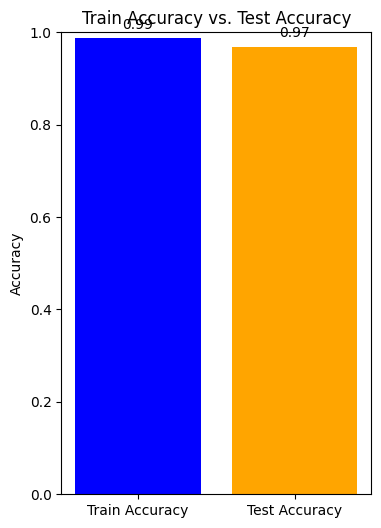

In [9]:
plt.figure(figsize=(4, 6))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Test Accuracy')
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()